In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
df = pd.read_csv('/Electric_Production.csv')

In [8]:
df

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


In [12]:
df.columns=['Date','Consumption']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


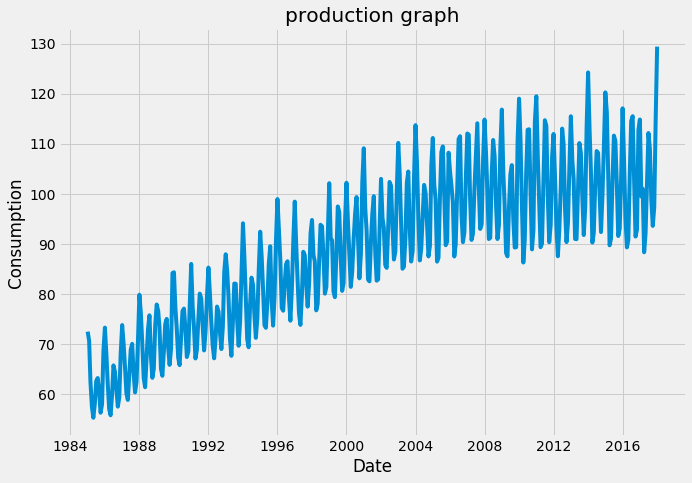

In [13]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

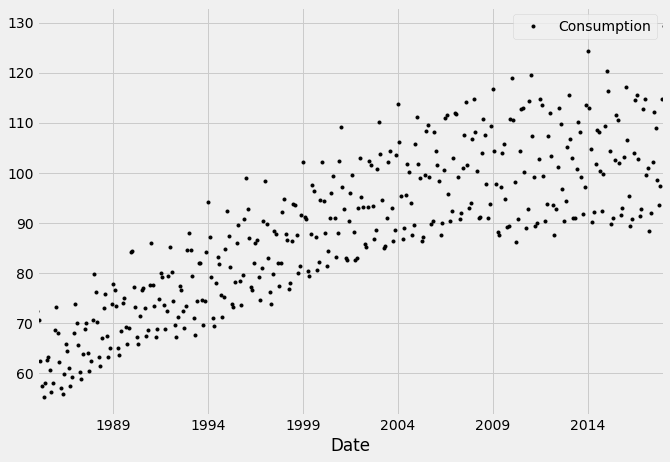

In [14]:
df.plot(style='k.')
plt.show()

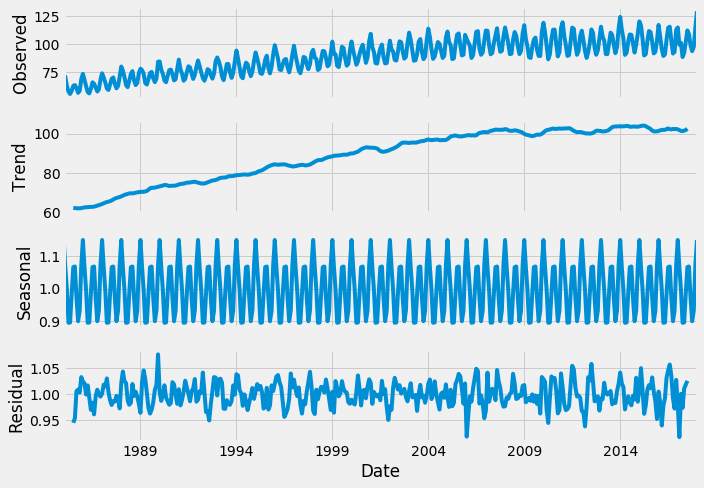

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

This gives us more insight into our data and real-world actions. Clearly, there is an upward trend and a recurring event where electricity consumption shoots maximum every year.

2. Stationarising the time series.

First, we need to check if a series is stationary or not.

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

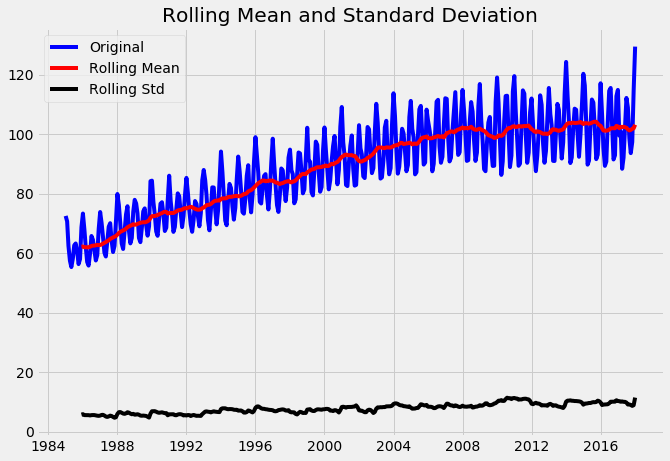

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

To get a stationary series, we need to eliminate the trend and seasonality from the series.

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series

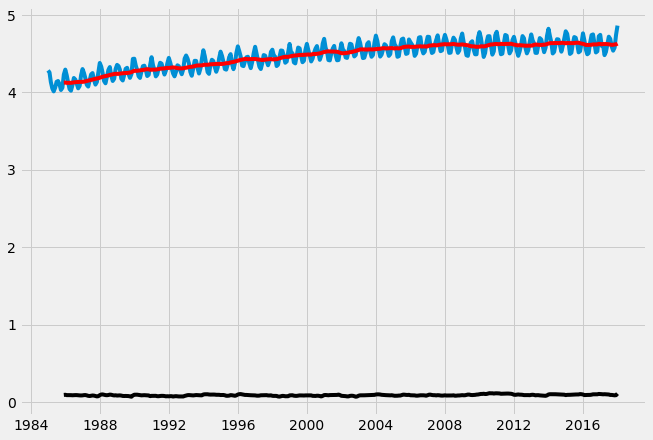

In [17]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [0]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

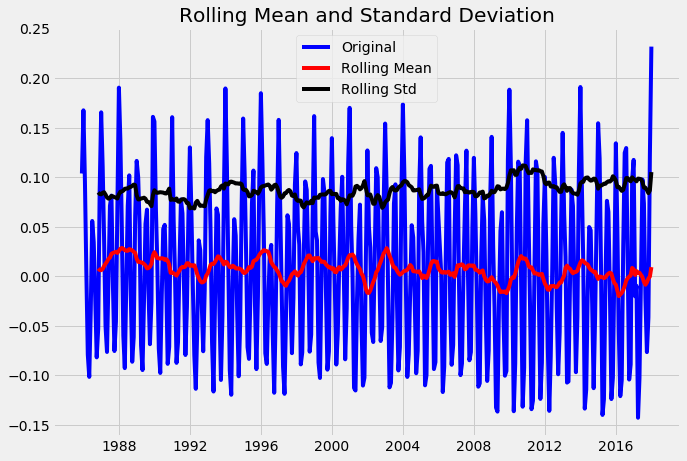

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [20]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.

In [0]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

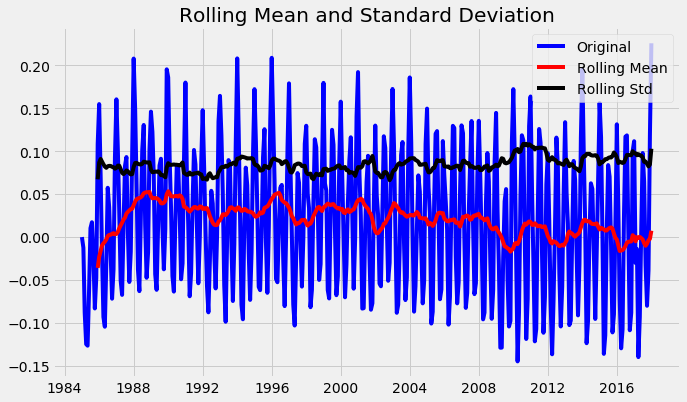

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [22]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

There can be cases when there is a high seasonality in the data.

In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.

Differencing is a method of transforming a time series dataset.

It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Differencing is performed by subtracting the previous observation from the current observation.
Perform the Dickey-Fuller test (ADFT) once again.

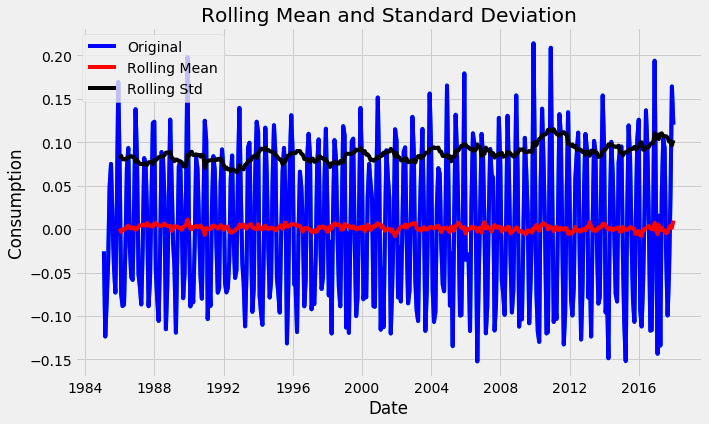

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [25]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Finally, perform the Dickey-Fuller test (ADFT) once again.

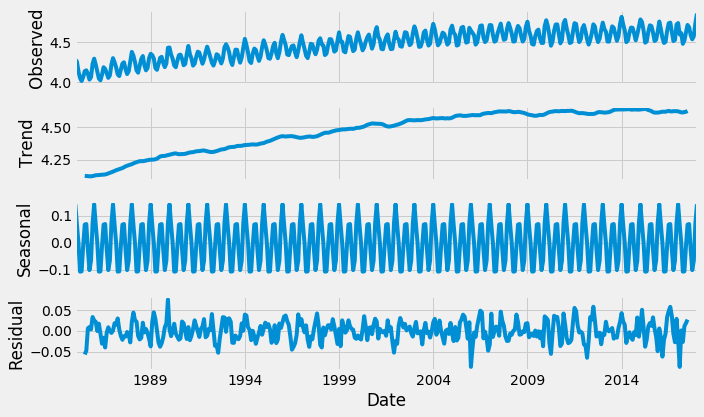

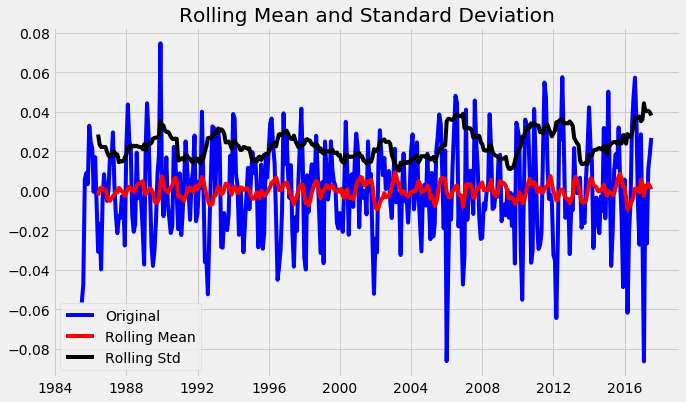

Results of dickey fuller test
Test Statistics               -1.000311e+01
p-value                        1.861632e-17
No. of lags used               1.400000e+01
Number of observations used    3.700000e+02
critical value (1%)           -3.448148e+00
critical value (5%)           -2.869383e+00
critical value (10%)          -2.570948e+00
dtype: float64


In [28]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity(residual)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation. We have got our stationary series and now we can move to find the best parameters for our model.

3. Finding the best parameters for our model

Before we go on to build our forecasting model, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms,

d → Number of nonseasonal differences needed for stationarity, and

q → Number of lagged forecast errors in the prediction equation.

Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

 

Autocorrelation Function(ACF)
 
Statistical correlation summarizes the strength of the relationship between two variables. Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

 

Partial Autocorrelation Function(PACF)
 
A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The autocorrelation for observation and observation at a prior time step is comprised of both the direct correlation and indirect correlations. It is these indirect correlations that the partial autocorrelation function seeks to remove.

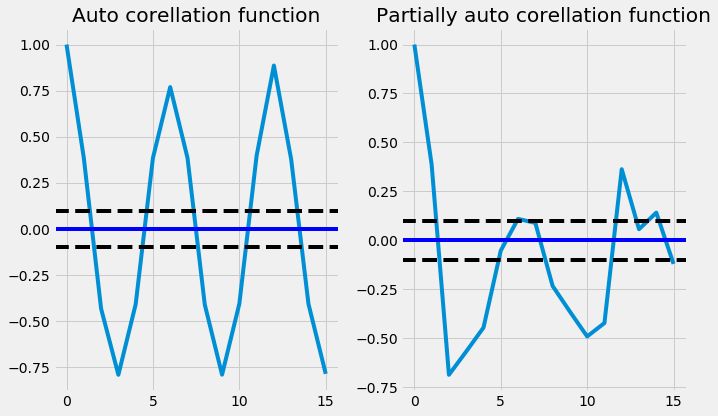

In [29]:
# ACF and PACF
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

# 4. Fitting model

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS : 0.522671


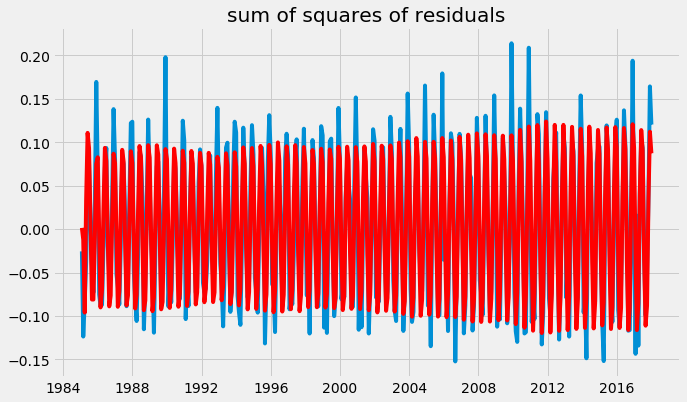

In [30]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

Less the RSS value, the more effective the model is. You check with (2,1,0),(3,1,1), etc to look for the smallest values of RSS
# ***5. Predictions***
The following code helps us to forecast for the next 6 years.

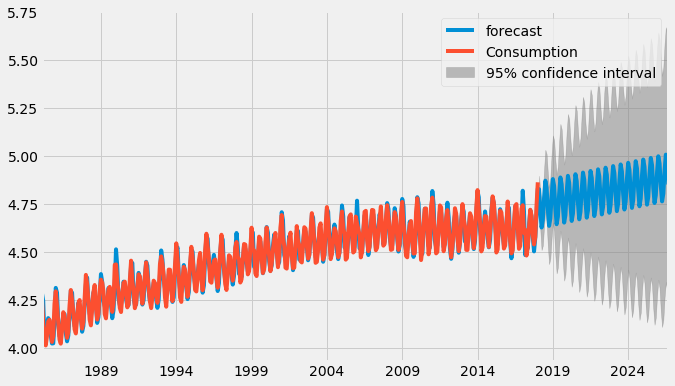

In [31]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)

From the above graph, we calculated the future predictions till 2024 the greyed out area is the confidence interval that means the predictions will not cross that area.